## Tutorial on large-scale Thompson sampling

This demo currently considers four approaches to discrete Thompson sampling on `m` candidates points:

1. **Exact sampling with Cholesky:** Computing a Cholesky decomposition of the corresponding `m x m` covariance matrix which reuqires `O(m^3)` computational cost and `O(m^2)` space. This is the standard approach to sampling from a Gaussian process, but the quadratic memory usage and cubic compliexity limits the number of candidate points.

2. **Contour integral quadrature (CIQ):** CIQ [1] is a Krylov subspace method combined with a rational approximation that can be used for computing matrix square roots of covariance matrices, which is the main bottleneck when sampling from a Gaussian process. CIQ relies on computing matrix vector multiplications with the exact kernel matrix which requires `O(m^2)` computational complexity and space. Note that the space complexity can be further lowered to `O(m)` by using [KeOps](https://github.com/getkeops/keops), but this is not covered as part of the tutorial.

3. **Lanczos:** Rather than using CIQ, we can solve the linear systems `K^(1/2) v = b` using Lanczos and the conjugate gradient (CG) method. This will be faster than CIQ, but will generally produce samples of worse quality. Similarly to CIQ, [KeOps](https://github.com/getkeops/keops) can be used to improve space complexity of Lanczos.

4. **Random Fourier features (RFFs):** The RFF kernel was originally proposed in [2] and we use it as implemented in GPyTorch. RFFs are computationally cheap to work with as the computational cost and space are both `O(km)` where `k` is the number of Fourier features.  Note that while Cholesky and CIQ are able to generate exact samples from the GP model, RFFs are an unbiased approximation and the resulting samples often aren't perfectly calibrated. 


[1] [Pleiss, Geoff, et al. "Fast matrix square roots with applications to Gaussian processes and Bayesian optimization.", Advances in neural information processing systems (2020)](https://proceedings.neurips.cc/paper/2020/file/fcf55a303b71b84d326fb1d06e332a26-Paper.pdf)

[2] [Rahimi, Ali, and Benjamin Recht. "Random features for large-scale kernel machines.", Advances in neural information processing systems (2007)](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf)

In [1]:
import os
import time
from contextlib import ExitStack

import gpytorch
import gpytorch.settings as gpts
import torch
from gpytorch.constraints import Interval
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import RBFKernel, RFFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.quasirandom import SobolEngine
from torch import Tensor

from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.test_functions import Hartmann
from botorch.utils.sampling import draw_sobol_samples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

We will use 6 dimensional Hartmann test function, which is typically evaluated on the unit hypercube.

In [2]:
hart6 = Hartmann(dim=6, negate=True).to(device=device, dtype=dtype)
dim = hart6.dim

In [3]:
def generate_batch(
    X: Tensor,
    Y: Tensor,
    batch_size: int,
    n_candidates: int,
    sampler: str,  # "cholesky", "ciq", "rff", "lanczos"
    seed: int,
) -> Tensor:
    assert sampler in ("cholesky", "ciq", "rff", "lanczos")
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))

    if sampler == "rff":
        base_kernel = RFFKernel(ard_num_dims=X.shape[-1], num_samples=1024)
    else:
        base_kernel = RBFKernel(ard_num_dims=X.shape[-1])
    covar_module = ScaleKernel(base_kernel)

    # Fit a GP model
    model = SingleTaskGP(train_X=X, train_Y=Y, covar_module=covar_module, outcome_transform=Standardize(m=1))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    # Draw samples on a Sobol sequence
    X_cand = draw_sobol_samples(bounds=hart6.bounds, n=n_candidates, q=1, seed=seed).squeeze(-2)

    # Thompson sample
    with ExitStack() as es:
        if sampler == "cholesky":
            es.enter_context(gpts.max_cholesky_size(float("inf")))
        elif sampler == "ciq":
            es.enter_context(gpts.fast_computations(covar_root_decomposition=True))
            es.enter_context(gpts.max_cholesky_size(0))
            es.enter_context(gpts.ciq_samples(True))
            es.enter_context(
                gpts.minres_tolerance(2e-3)
            )  # Controls accuracy and runtime
            es.enter_context(gpts.num_contour_quadrature(15))
        elif sampler == "lanczos":
            es.enter_context(
                gpts.fast_computations(
                    covar_root_decomposition=True, log_prob=True, solves=True
                )
            )
            es.enter_context(gpts.max_lanczos_quadrature_iterations(10))
            es.enter_context(gpts.max_cholesky_size(0))
            es.enter_context(gpts.ciq_samples(False))
        elif sampler == "rff":
            es.enter_context(gpts.fast_computations(covar_root_decomposition=True))
        es.enter_context(torch.no_grad())
        
        thompson_sampling = MaxPosteriorSampling(model=model, replacement=False)
        X_next = thompson_sampling(X_cand, num_samples=batch_size)

    return X_next

In [4]:
def run_optimization(
    sampler: str,
    n_candidates: int,
    n_init: int,
    max_evals: int,
    batch_size: int,
    seed: int,
) -> tuple[Tensor, Tensor]:
    X = draw_sobol_samples(bounds=hart6.bounds, n=n_init, q=1, seed=seed).squeeze(-2)
    Y = torch.tensor(
        [hart6(x) for x in X], dtype=dtype, device=device
    ).unsqueeze(-1)
    print(f"{len(X)}) Best value: {Y.max().item():.2e}")

    inner_seed = seed
    while len(X) < max_evals:
        # Create a batch
        start = time.monotonic()
        inner_seed += 1
        X_next = generate_batch(
            X=X,
            Y=Y,
            batch_size=min(batch_size, max_evals - len(X)),
            n_candidates=n_candidates,
            seed=inner_seed,
            sampler=sampler,
        )
        end = time.monotonic()
        print(f"Generated batch in {end - start:.1f} seconds")
        Y_next = torch.tensor(
            [hart6(x) for x in X_next], dtype=dtype, device=device
        ).unsqueeze(-1)

        # Append data
        X = torch.cat((X, X_next), dim=0)
        Y = torch.cat((Y, Y_next), dim=0)

        print(f"{len(X)}) Best value: {Y.max().item():.2e}")
    return X, Y

In [5]:
batch_size = 5
n_init = 10
max_evals = 50
seed = 12345  # To get the same Sobol points
N_CAND = 10_000 if not SMOKE_TEST else 10

shared_args = {
    "n_candidates": N_CAND,
    "n_init": n_init,
    "max_evals": max_evals,
    "batch_size": batch_size,
    "seed": seed,
}

## Track memory footprint

In [6]:
%load_ext memory_profiler

## Cholesky

In [7]:
%memit X_chol, Y_chol = run_optimization("cholesky", **shared_args)

10) Best value: 6.72e-01


/opt/anaconda3/envs/botorch/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Generated batch in 16.0 seconds
15) Best value: 6.72e-01


/opt/anaconda3/envs/botorch/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Generated batch in 14.1 seconds
20) Best value: 6.72e-01


/opt/anaconda3/envs/botorch/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Generated batch in 18.6 seconds
25) Best value: 1.94e+00


/opt/anaconda3/envs/botorch/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Generated batch in 14.8 seconds
30) Best value: 1.94e+00
Generated batch in 13.9 seconds
35) Best value: 2.11e+00
Generated batch in 14.0 seconds
40) Best value: 2.68e+00
Generated batch in 14.6 seconds
45) Best value: 2.98e+00
Generated batch in 14.7 seconds
50) Best value: 2.98e+00
peak memory: 7941.41 MiB, increment: 7674.36 MiB


## RFFs

In [8]:
%memit X_rff, Y_rff = run_optimization("rff", **shared_args)

10) Best value: 6.72e-01
Generated batch in 1.4 seconds
15) Best value: 6.72e-01
Generated batch in 2.6 seconds
20) Best value: 6.72e-01
Generated batch in 2.0 seconds
25) Best value: 1.00e+00
Generated batch in 2.0 seconds
30) Best value: 1.36e+00
Generated batch in 2.5 seconds
35) Best value: 2.00e+00
Generated batch in 2.2 seconds
40) Best value: 2.43e+00
Generated batch in 2.2 seconds
45) Best value: 2.43e+00
Generated batch in 2.1 seconds
50) Best value: 2.65e+00
peak memory: 1709.20 MiB, increment: 1349.06 MiB


## Lanczos

In [9]:
%memit X_lanczos, Y_lanczos = run_optimization("lanczos", **shared_args)

10) Best value: 6.72e-01
Generated batch in 1.9 seconds
15) Best value: 6.72e-01
Generated batch in 2.5 seconds
20) Best value: 1.83e+00
Generated batch in 2.4 seconds
25) Best value: 1.93e+00
Generated batch in 2.6 seconds
30) Best value: 2.39e+00
Generated batch in 2.5 seconds
35) Best value: 2.41e+00
Generated batch in 2.5 seconds
40) Best value: 2.96e+00
Generated batch in 2.6 seconds
45) Best value: 2.98e+00
Generated batch in 2.5 seconds
50) Best value: 2.98e+00
peak memory: 2981.11 MiB, increment: 1271.91 MiB


## CIQ

In [10]:
%memit X_ciq, Y_ciq = run_optimization("ciq", **shared_args)

10) Best value: 6.72e-01
Generated batch in 9.6 seconds
15) Best value: 6.72e-01
Generated batch in 12.5 seconds
20) Best value: 6.72e-01
Generated batch in 16.8 seconds
25) Best value: 6.72e-01
Generated batch in 18.7 seconds
30) Best value: 2.19e+00
Generated batch in 18.2 seconds
35) Best value: 2.48e+00
Generated batch in 14.8 seconds
40) Best value: 2.61e+00
Generated batch in 15.2 seconds
45) Best value: 2.98e+00
Generated batch in 15.9 seconds
50) Best value: 2.98e+00
peak memory: 2674.38 MiB, increment: 908.34 MiB


## Plot

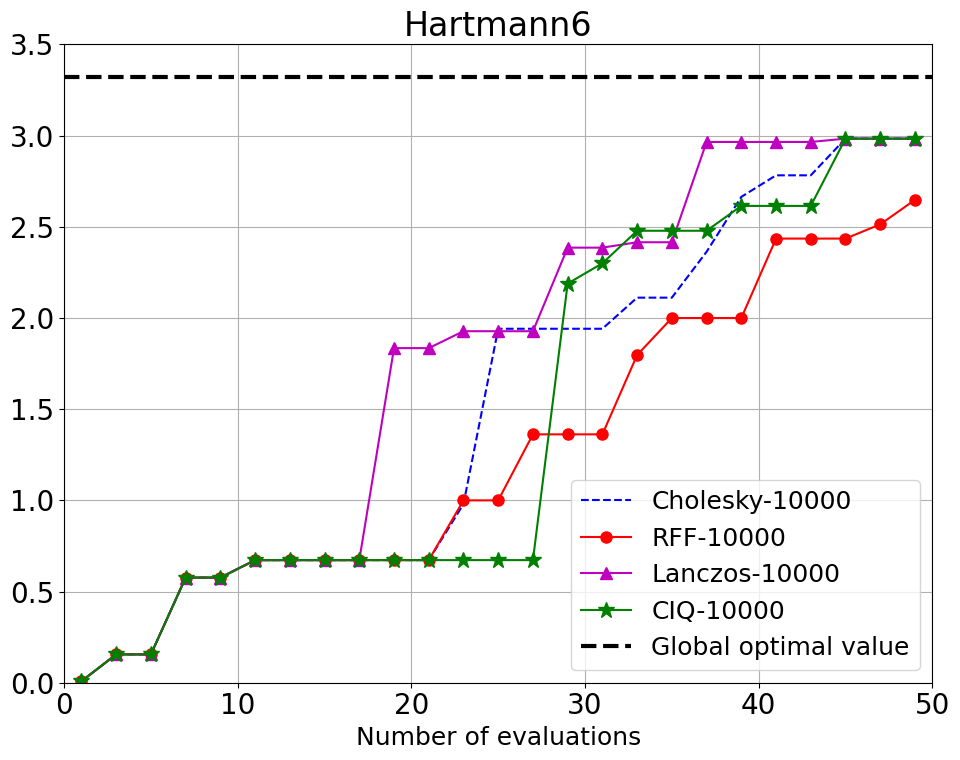

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(10, 8))
matplotlib.rcParams.update({"font.size": 20})

results = [
    (Y_chol.cpu(), f"Cholesky-{N_CAND}", "b", "", 14, "--"),
    (Y_rff.cpu(), f"RFF-{N_CAND}", "r", ".", 16, "-"),
    (Y_lanczos.cpu(), f"Lanczos-{N_CAND}", "m", "^", 9, "-"),
    (Y_ciq.cpu(), f"CIQ-{N_CAND}", "g", "*", 12, "-"),
]

optimum = hart6.optimal_value

ax = fig.add_subplot(1, 1, 1)
names = []
for res, name, c, m, ms, ls in results:
    names.append(name)
    fx = res.cummax(dim=0)[0]
    t = 1 + np.arange(len(fx))
    plt.plot(t[0::2], fx[0::2], c=c, marker=m, linestyle=ls, markersize=ms)

plt.plot([0, max_evals], [hart6.optimal_value, hart6.optimal_value], "k--", lw=3)
plt.xlabel("Function value", fontsize=18)
plt.xlabel("Number of evaluations", fontsize=18)
plt.title("Hartmann6", fontsize=24)
plt.xlim([0, max_evals])
plt.ylim([0, 3.5])

plt.grid(True)
plt.tight_layout()
plt.legend(
    names + ["Global optimal value"],
    loc="lower right",
    ncol=1,
    fontsize=18,
)
plt.show()